In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV

import pickle


Below are some utility functions I made to abstract re-used code:

In [3]:

def grid_search_results(grid_search: GridSearchCV):
    """
    Processes and outputs results from a grid search.
    Args:
        grid_search (GridSearchCV) : Sklearn GridSearchCV object after fitting training data
    Returns:
        tuple: best_model, best_params, best_score, cv_results
    """
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = -grid_search.best_score_

    # print the RMSE for each feature combination from cv_results_
    cv_results = grid_search.cv_results_

    for mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
        rmse = -mean_score
        print(f"Params: {params}\n- RMSE: {rmse:.2f}\n")

    # print best parameters and the best model
    print(f"Best Parameters: {best_params}\n")
    print(f"Best Model: {best_model}\n")
    print(f"Best RMSE: {best_score:.1f}")

    return best_model, best_params, best_score, cv_results

def rmse_stats(rmses: list):
    """
    Prints mean/standard deviation of RMSEs, and a list of Root Mean Squared Errors (RMSEs).
        - RMSEs from cross-validation,
    Args:
        rmses (list) : list of floats for RMSEs calculated from cross-validation
    Returns:
        tuple : rmses, mean_rmse, stf_rmse
    """
    rmses = np.array(rmses)
    mean_rsme = np.mean(rmses)
    std_rmse = np.std(rmses)
    
    print(f'RMSEs : {rmses}')
    print(f'Mean of RMSEs: {mean_rsme}')
    print(f'Std of RMSEs: {std_rmse}')

    return rmses, mean_rsme, std_rmse


# Load Data

In [4]:
# load the data and print the desctiption
data = load_diabetes()
print(data['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

# Part 1: Data Exploration

- Check data types
- Check nulls
- Summary statistics
- Histogram / skew of features
- Create a correlation matrix / correlation heatmap
- Create a pairplot of top 3 correlated features
- Data preprocessing

In [5]:
df = pd.DataFrame(data['data'], columns=data['feature_names']).assign(target=data['target'])

In [6]:
# check dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
 10  target  442 non-null    float64
dtypes: float64(11)
memory usage: 38.1 KB


In [7]:
# check for nulls
df.isna().sum()

age       0
sex       0
bmi       0
bp        0
s1        0
s2        0
s3        0
s4        0
s5        0
s6        0
target    0
dtype: int64

In [8]:
# quick lil 5 num summary
df.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,442.000000
mean,-2.511817e-19,1.230790e-17,-2.245564e-16,-4.797570e-17,-1.381499e-17,3.918434e-17,-5.777179e-18,-9.042540e-18,9.293722e-17,1.130318e-17,152.133484
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,77.093005
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123988e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260971e-01,-1.377672e-01,25.000000
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665608e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324559e-02,-3.317903e-02,87.000000
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670422e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947171e-03,-1.077698e-03,140.500000
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564379e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243232e-02,2.791705e-02,211.500000
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320436e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335973e-01,1.356118e-01,346.000000


Based on the description as well as the output of `df.describe()` all features have been scaled via mean centering. We can see that the mean of each feature is centered at around ~ 0 while keeping the original distribution of the data. In addition, the standard deviation between all features look to be around the same value (~ -0.05) and the range looks to also be very similar. Given this, further transformation does not seem to be necessary; however, to further assess the need for transformations, we can look at the histograms of each individual feature.  

### Feature Distribution 

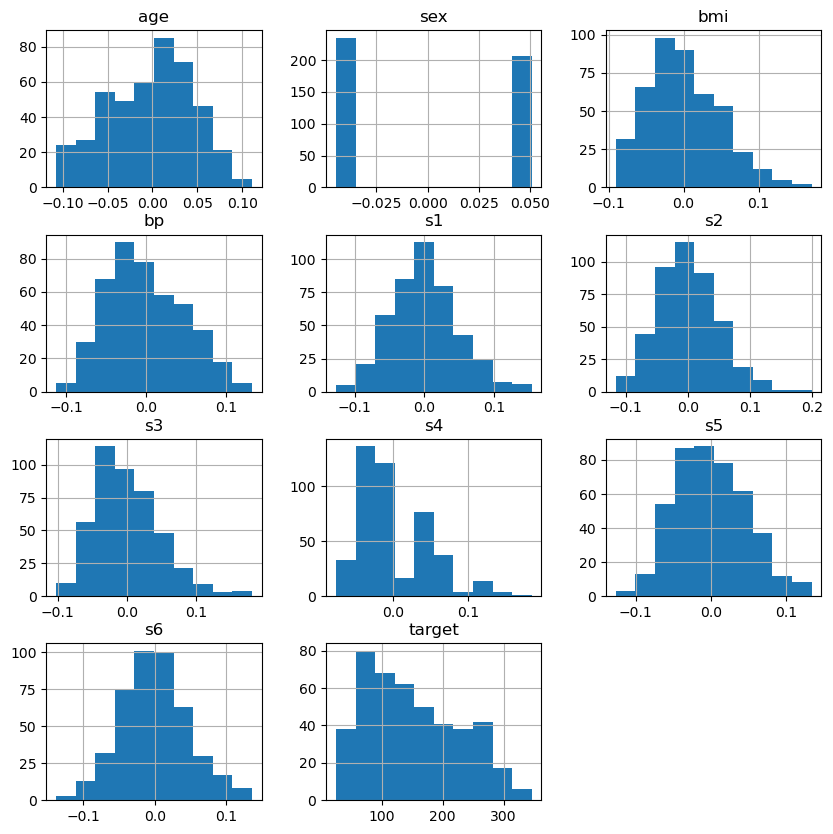

In [9]:
features = data['feature_names']
# for feature in features:
#     plt.figure()  
#     sns.histplot(x=df[feature])
#     plt.title(f'Histogram of {feature}')  
#     plt.show() 

df.hist(figsize=(10,10))
plt.show()

Looking at the given features, most of them are visually normal. We can do further statistical tests on normality (Shapiro-Wilk test, QQ-plots, etc.) but I will just stick to visual analysis. 

The normally distributed features look to be:
- age   
- bmi   
- bp 
- s1 (tc, total serum cholesterol)
- s2 (ldl, low-density lipoproteins)
- s5 (ltg, possibly log of serum triglycerides level)
- s6  (glu, blood sugar level)

Non-normal:
- sex
    - binomial?
- s3 (hdl, high-density lipoproteins) 
    - right skew?
- s4 (tch, total cholesterol / HDL)
    - right skew?

Overall, no extra pre-processing is needed to transform the distributions. 

In addition to the overall distribution, we can also inspect skew using `df.skew()`. A value of 0 means no skew, a positive value is right skew, and a negative skew is left skew. 

Given this, we'd expect age, s3, and s4 to have larger skew values.

In [10]:
df.skew().sort_values(ascending=False)

s3        0.799255
s4        0.735374
bmi       0.598148
target    0.440563
s2        0.436592
s1        0.378108
s5        0.291754
bp        0.290658
s6        0.207917
sex       0.127385
age      -0.231382
dtype: float64

Using `df.skew()`, s3 and s4 have the strongest right skew while age is the only value of with left skew. 


### Correlation Analysis 

We can now dive into mild correlation analysis between individual variables and the target via:
1. `sns.lmplot()` to plat a scatter/line plot
2. `df.corr()` to return the correlation coefficients
3. `sns.heatmap()` to create a correlation heatmap

In [11]:
# for feature in features:
#     sns.lmplot(x=feature, y='target', data=df)
#     plt.title(f'{feature} vs target')
#     plt.show()

In [12]:
# correlation matrix
df.corr()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
age,1.000000,0.173737,0.185085,0.335428,0.260061,0.219243,-0.075181,0.203841,0.270774,0.301731,0.187889
sex,0.173737,1.000000,0.088161,0.241010,0.035277,0.142637,-0.379090,0.332115,0.149916,0.208133,0.043062
bmi,0.185085,0.088161,1.000000,0.395411,0.249777,0.261170,-0.366811,0.413807,0.446157,0.388680,0.586450
bp,0.335428,0.241010,0.395411,1.000000,0.242464,0.185548,-0.178762,0.257650,0.393480,0.390430,0.441482
s1,0.260061,0.035277,0.249777,0.242464,1.000000,0.896663,0.051519,0.542207,0.515503,0.325717,0.212022
s2,0.219243,0.142637,0.261170,0.185548,0.896663,1.000000,-0.196455,0.659817,0.318357,0.290600,0.174054
s3,-0.075181,-0.379090,-0.366811,-0.178762,0.051519,-0.196455,1.000000,-0.738493,-0.398577,-0.273697,-0.394789
s4,0.203841,0.332115,0.413807,0.257650,0.542207,0.659817,-0.738493,1.000000,0.617859,0.417212,0.430453
s5,0.270774,0.149916,0.446157,0.393480,0.515503,0.318357,-0.398577,0.617859,1.000000,0.464669,0.565883
s6,0.301731,0.208133,0.388680,0.390430,0.325717,0.290600,-0.273697,0.417212,0.464669,1.000000,0.382483


<AxesSubplot:>

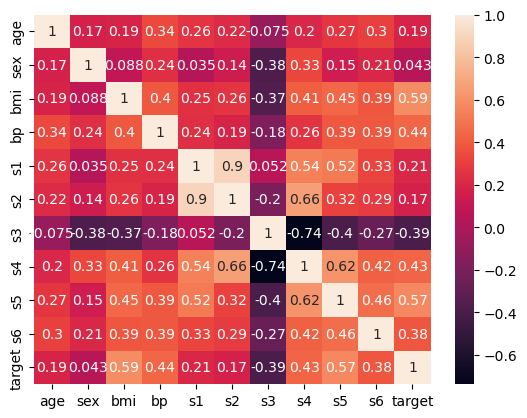

In [13]:
# correlation heatmap
sns.heatmap(df.corr(), annot=True)

In [14]:
# print out correlation between features / target in descending order
df.corr()['target'].sort_values(ascending=False)

target    1.000000
bmi       0.586450
s5        0.565883
bp        0.441482
s4        0.430453
s6        0.382483
s1        0.212022
age       0.187889
s2        0.174054
sex       0.043062
s3       -0.394789
Name: target, dtype: float64

Visually, bmi and blood pressure look to be the top contenders for the strongest correlation with the target. Looking at the correlation coefficeints, we can see that the top 4 strongest correlated features in order are:
1. bmi 
2. s5
3. bp
4. s4

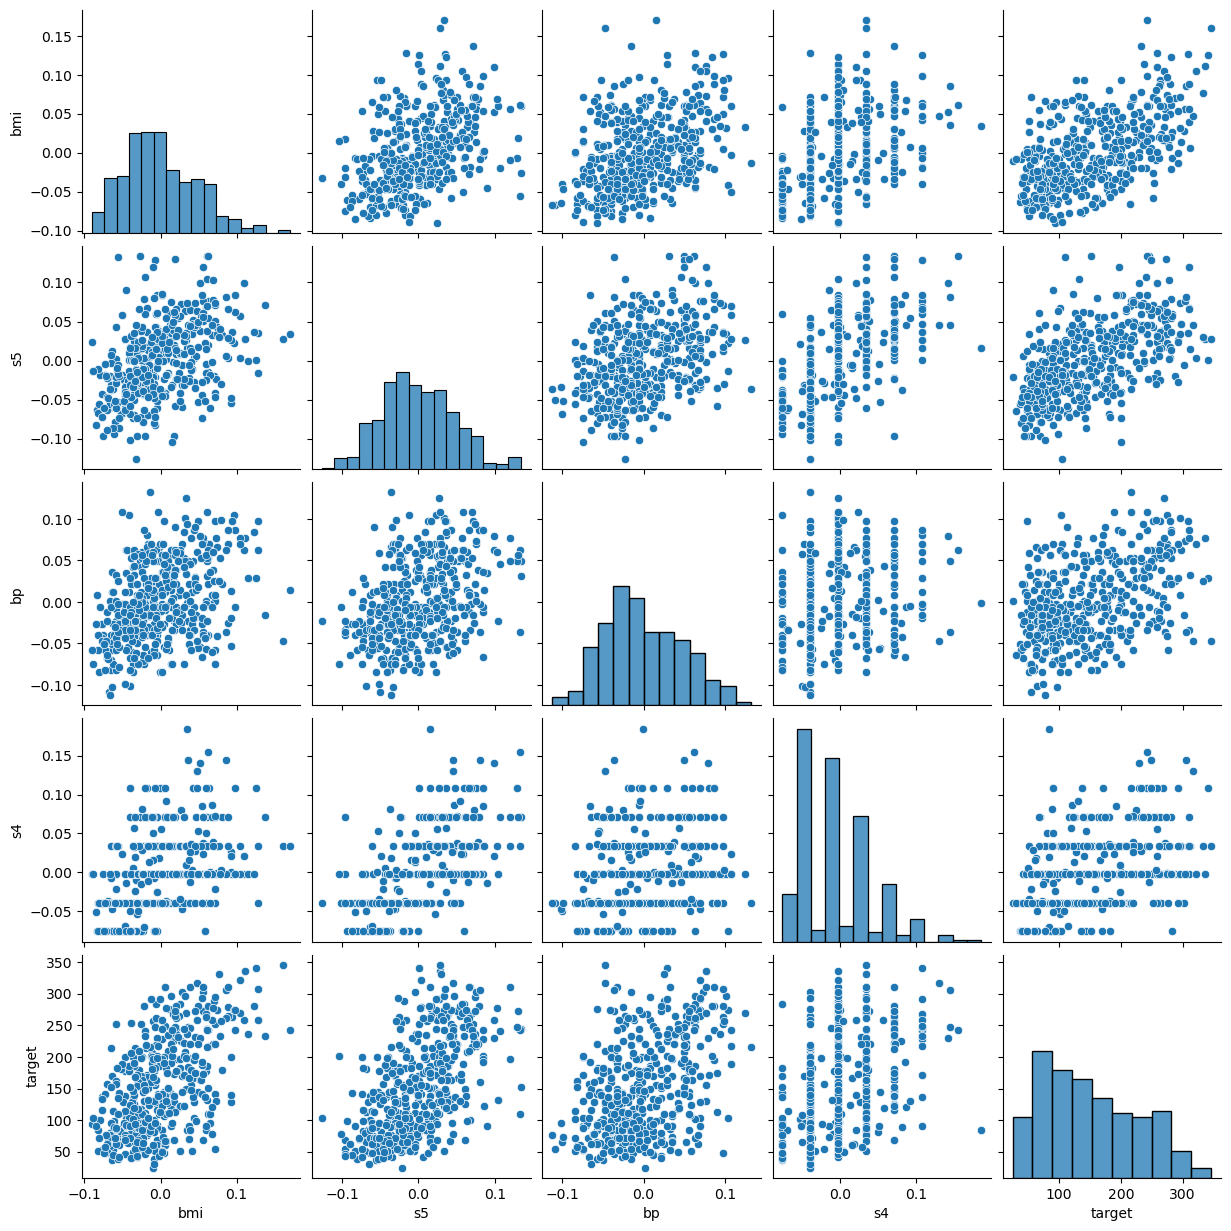

In [15]:
# pairplot of top 3 correlated features w/ target
sns.pairplot(df[['bmi', 's5', 'bp', 's4', 'target']])

plt.show()

# Data Preprocessing

- create feature matrix (X) and target vector (y)
- split data into 80% training and 20% testing

In [16]:
# create arrays and split data

# for all features
X = df.loc[:, df.columns != 'target'].to_numpy()

# for bmi only
x = df['bmi'].to_numpy().reshape(-1,1)

# target
y = df['target'].to_numpy()

# full feature train/test set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=432)

# single feature (BMI) train/test set
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.80, random_state=432)

In [17]:
# validate split
print(X_train.shape)
print(X_test.shape)

(353, 10)
(89, 10)


# Part 2: Model Training

- create sklearn pipeline class objects for each regressor type
- train a linear regressor on training set (w/out cross validation)
- train regressor w/ cross-validation for:
    - linear regression
    - random forest regression
    - decision tree regressor

In [18]:
linear_regressor = Pipeline(
    steps = 
    [
        # pre-processing steps usually in this pipeline,
        ('linear_regression', LinearRegression())
    ]
)

random_forest_regressor = Pipeline(
    steps = 
    [
        # pre-processing steps usually in this pipeline,
        ('random_forest', RandomForestRegressor(random_state=432))
    ]
)

decision_tree_regressor = Pipeline(
    steps = 
    [
        # pre-processing steps usually in this pipeline,
        ('decision_tree', DecisionTreeRegressor(random_state=432))
    ]
)


#### Training with cross validation
1. Linear regressor
2. Random forest regressor
3. decision tree regressor
3. Linear regressor - BMI only

In [19]:
# linear regressor on all features
linear_rmses = -cross_val_score(linear_regressor, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
rmses_lr, mean_lr_rmse, std_lr_rmse = rmse_stats(linear_rmses)

RMSEs : [51.40006296 56.37103167 52.49708992 60.5519805  54.76727506]
Mean of RMSEs: 55.117488021751015
Std of RMSEs: 3.2222186322565785


In [20]:
# random forest on all features
random_forest_rmses = -cross_val_score(random_forest_regressor, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
rmses_rf, mean_rf_rmse, std_rf_rmse = rmse_stats(random_forest_rmses)

RMSEs : [56.11459571 58.24159745 52.77944074 61.13477029 60.08311003]
Mean of RMSEs: 57.67070284535337
Std of RMSEs: 2.982995365588225


In [21]:
# decision tree on all features
decision_tree_rmses = -cross_val_score(decision_tree_regressor, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
rmses_dt, mean_dt_rmse, std_dt_rmse = rmse_stats(decision_tree_rmses)

RMSEs : [81.02946777 78.24870066 71.87518524 86.32025089 84.30785424]
Mean of RMSEs: 80.35629176092095
Std of RMSEs: 5.059800954716738


In [22]:
# linear regressor on single feature, BMI
linear_bmi_rmses = -cross_val_score(linear_regressor, x_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
rmses_lt_bmi, mean_lt_bmi_rmse, std_lt_bmi_rmse = rmse_stats(linear_bmi_rmses)

RMSEs : [63.32371968 66.52854268 57.39954301 64.87527931 61.60305958]
Mean of RMSEs: 62.74602885238086
Std of RMSEs: 3.132607051240467


### Preliminary Results

Linear Regressor:
- mean RMSE: 55.1
- std RMSE:  3.2

Random Forest Regressor:
- mean RMSE: 57.7
- std RMSE: 2.3

Decision Tree Regressor:
- mean RMSE: 80.4
- std RMSE: 5.1

Linear Regressor - BMI:
- mean RMSE: 62.7
- std RMSE:  3.1

Based on the cross validation performance of all three models, __linear regression__ on all features looks to have the loweset RMSE. Between the random forest regressor and the decision tree regressor, the __random forest regressor__ has the lower RMSE.

# Part 3: Model Tuning - Decision Tree

### Grid Search CV
1. Decision Tree

##### Decision Tree GridSearchCV

In [23]:
# default params for DT Regressor
print('Decision Tree Regressor Default Params:')
DecisionTreeRegressor(random_state=432).get_params()

Decision Tree Regressor Default Params:


{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 432,
 'splitter': 'best'}

In [24]:
param_grid = {
    'decision_tree__max_depth': list(range(1, 20)),  
    'decision_tree__min_samples_leaf': list(range(1, 51)) 
}

grid_search_dt = GridSearchCV(decision_tree_regressor, param_grid, cv=5, scoring='neg_root_mean_squared_error')
grid_search_dt.fit(X_train, y_train)

best_model_dt, best_params_dt, best_score_dt, cv_results_dt = grid_search_results(grid_search_dt)

Params: {'decision_tree__max_depth': 1, 'decision_tree__min_samples_leaf': 1}
- RMSE: 66.67

Params: {'decision_tree__max_depth': 1, 'decision_tree__min_samples_leaf': 2}
- RMSE: 66.67

Params: {'decision_tree__max_depth': 1, 'decision_tree__min_samples_leaf': 3}
- RMSE: 66.67

Params: {'decision_tree__max_depth': 1, 'decision_tree__min_samples_leaf': 4}
- RMSE: 66.67

Params: {'decision_tree__max_depth': 1, 'decision_tree__min_samples_leaf': 5}
- RMSE: 66.67

Params: {'decision_tree__max_depth': 1, 'decision_tree__min_samples_leaf': 6}
- RMSE: 66.67

Params: {'decision_tree__max_depth': 1, 'decision_tree__min_samples_leaf': 7}
- RMSE: 66.67

Params: {'decision_tree__max_depth': 1, 'decision_tree__min_samples_leaf': 8}
- RMSE: 66.67

Params: {'decision_tree__max_depth': 1, 'decision_tree__min_samples_leaf': 9}
- RMSE: 66.67

Params: {'decision_tree__max_depth': 1, 'decision_tree__min_samples_leaf': 10}
- RMSE: 66.67

Params: {'decision_tree__max_depth': 1, 'decision_tree__min_samples_l

# Part 4: Model Tuning - Random Forest

### Grid Search CV
1. Random Forest

##### Random Forest GridSearchCV

In [25]:
print('Random Forest Regressor Default Params:')

RandomForestRegressor(random_state=432).get_params()

Random Forest Regressor Default Params:


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 432,
 'verbose': 0,
 'warm_start': False}

In [26]:
param_grid = {
    'random_forest__n_estimators': [100, 200, 400, 500],
    'random_forest__max_features': [2, 4, 6, 8, 10]
}

grid_search_rf = GridSearchCV(random_forest_regressor, param_grid, cv=5, scoring='neg_root_mean_squared_error')
grid_search_rf.fit(X_train, y_train)

best_model_rf, best_params_rf, best_score_rf, cv_results_rf = grid_search_results(grid_search_rf)

Params: {'random_forest__max_features': 2, 'random_forest__n_estimators': 100}
- RMSE: 56.60

Params: {'random_forest__max_features': 2, 'random_forest__n_estimators': 200}
- RMSE: 56.24

Params: {'random_forest__max_features': 2, 'random_forest__n_estimators': 400}
- RMSE: 56.32

Params: {'random_forest__max_features': 2, 'random_forest__n_estimators': 500}
- RMSE: 56.31

Params: {'random_forest__max_features': 4, 'random_forest__n_estimators': 100}
- RMSE: 56.67

Params: {'random_forest__max_features': 4, 'random_forest__n_estimators': 200}
- RMSE: 56.58

Params: {'random_forest__max_features': 4, 'random_forest__n_estimators': 400}
- RMSE: 56.40

Params: {'random_forest__max_features': 4, 'random_forest__n_estimators': 500}
- RMSE: 56.29

Params: {'random_forest__max_features': 6, 'random_forest__n_estimators': 100}
- RMSE: 56.38

Params: {'random_forest__max_features': 6, 'random_forest__n_estimators': 200}
- RMSE: 56.67

Params: {'random_forest__max_features': 6, 'random_forest__n

### Feature Importance 
- from the best performing random forest regressor

In [27]:
feature_importance = grid_search_rf.best_estimator_.named_steps['random_forest'].feature_importances_

pd.DataFrame({
    'feature': features,
    'importance': feature_importance
}).sort_values(by='importance', ascending=False)

,feature,importance
2,bmi,0.197143
8,s5,0.190879
3,bp,0.128155
9,s6,0.103076
6,s3,0.078674
7,s4,0.077432
5,s2,0.074039
4,s1,0.070197
0,age,0.065763
1,sex,0.014643


Based on the correlation we saw that bmi, s5, and bp were the top 3 most correlated to the target. After training the random forest regressor on the traning set, we see that the top 3 most important features as learned by the model were also bmi, s5, and bp. As expected the most correlated features tend to have the most importance in predictive power in this random forest regressor.

# Part 5: Model Evaluation

Compare the average RMSE values from the following trained challenger models:
1. Linear Regressor with entire training data
2. Decision Tree Regressor 
3. Random Forest Regressor
4. Linear Regressor with the single best feature found in Assignment 1
5. Tuned decision tree  
6. Tuned random forest

In [28]:
# final results of each model's final RMSE
pd.DataFrame({
    'model':['lr_all', 'dt_all', 'rf_all', 'lr_bmi', 'dt_all_tuned', 'rf_all_tuned'],
    'rmse': np.round([mean_lr_rmse, mean_dt_rmse,  mean_rf_rmse, mean_lt_bmi_rmse, best_score_dt, best_score_rf], 1)
    }).sort_values(by='rmse', ascending=True)

,model,rmse
0,lr_all,55.1
5,rf_all_tuned,56.2
2,rf_all,57.7
4,dt_all_tuned,60.4
3,lr_bmi,62.7
1,dt_all,80.4


Based on the final RMSEs of the 6 models evaluated, the linear regression trained on all data has the lowest score of 55.1. Therefore, I will use it as the final model and will evaulate it on the test set.

In [31]:
# evalute the best model on the test set
linear_regressor.fit(X_train, y_train)
y_pred = linear_regressor.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Linear Regression (all features) RMSE: {test_rmse:.1f}")

Linear Regression (all features) RMSE: 52.7


The average RMSE over the training data for this model was 55.1. Over the testing data, the RMSE actually improved to 52.7. In comparison to all the other challenger models, the linear regression trained on all features has performed the best, even when evaluated on the testing data.

In [30]:
# save the model as a pickle file
with open('linear_regression_model.pkl', 'wb') as file:
    pickle.dump(linear_regressor, file)